# RTL-SDR Data Acquisition test
Copyright (C) 2018 William Meng

This file is part of rtl_ultrasound

rtl_ultrasound is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

rtl_ultrasound is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with rtl_ultrasound.  If not, see <http://www.gnu.org/licenses/>.

-------

William Meng K9TTL  
Aug 12, 2018

In this notebook, I will be testing the capabilities of the RTL-SDR as a time-domain data acquisition tool.

In [1]:
%matplotlib inline

## Using pyrtlsdr
[pyrtlsdr](https://github.com/roger-/pyrtlsdr) is a library that makes it super easy
to use the RTL-SDR with Python.

/usr/local/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


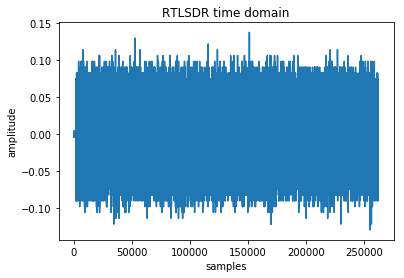

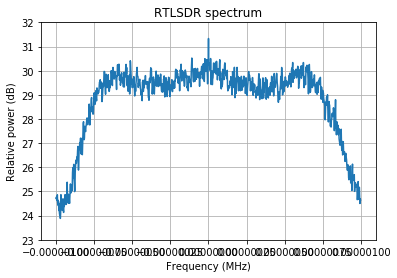

In [10]:
from pylab import *
from rtlsdr import *

sdr = RtlSdr()

# configure device
sdr.sample_rate = 2.4e6
sdr.center_freq = 95e6
sdr.gain = 'auto'

samples = sdr.read_samples(256*1024)
sdr.close()

f = sdr.sample_rate
plt.plot(samples)
plt.xlabel('samples')
plt.ylabel('amplitude')
plt.title('RTLSDR time domain')
plt.show()

# use matplotlib to estimate and plot the PSD
plt.psd(samples, NFFT=1024, Fs=sdr.sample_rate/1e6, Fc=sdr.center_freq/1e6)
plt.xlabel('Frequency (MHz)')
plt.ylabel('Relative power (dB)')
plt.title('RTLSDR spectrum')
plt.show()

Cool, we were able to pick up some radio noise!

## Direct Sampling
Function generator 2.04MHz "dirty" sine wave
→ BNC → BNC splitter → BNC-to-SMA adapter → SMA → RTL-SDR

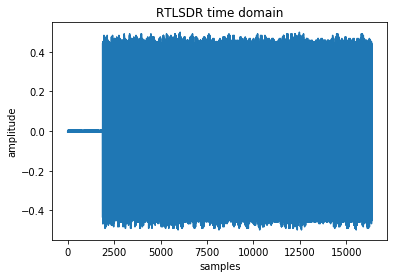

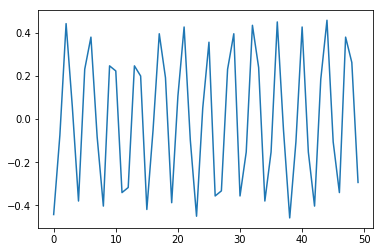

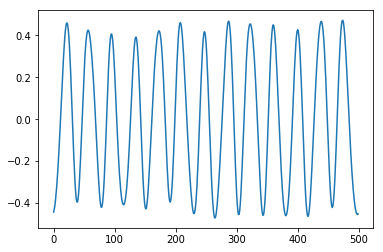

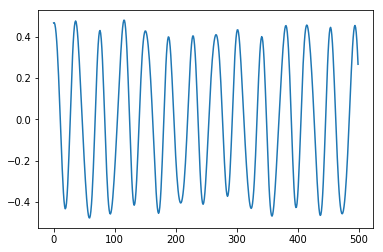

In [46]:
import matplotlib.pyplot as plt
from rtlsdr import *

sdr = RtlSdr()

# configure device
sdr.set_direct_sampling(2) # directly sample I channel
sdr.gain = 1

#samples = sdr.read_samples(256*1024)
samples = sdr.read_samples(256*64)
samples = np.real(samples)
sdr.close()

f = sdr.sample_rate
plt.plot(samples)
plt.xlabel('samples')
plt.ylabel('amplitude')
plt.title('RTLSDR time domain')
plt.show()

zoomed_samples = samples[7450:7500]
plt.plot(zoomed_samples)
plt.show()

from scipy.signal import resample
resampled = resample(zoomed_samples, len(zoomed_samples)*10)
plt.plot(resampled)
plt.show()

resample_then_zoom = resample(samples, len(samples)*10)[100000:100500]
plt.plot(resample_then_zoom)
plt.show()

Frequency looks about right.
Between 2 and 3 periods in 10 samples.

Looks like there is some unintentional amplitude modulation going on.
Possibly due to the really lousy function generator.
Or quantization noise from the 8 bit ADC in RTL SDR.
Or harmonics of the dirty sine wave are folded over 14.4 MHz due to the lack of AAF.

/usr/local/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


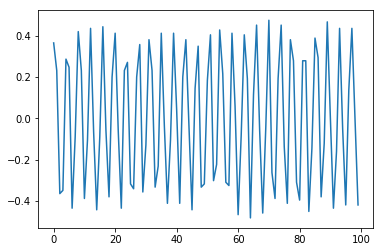

In [32]:
plt.plot(samples[7400:7500])
plt.show()

## With AAF
Function generator
→ BNC → BNC splitter → BNC-to-SMA adapter → 12.5 MHz lowpass filter → SMA → RTL-SDR

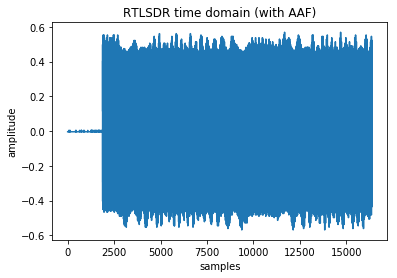

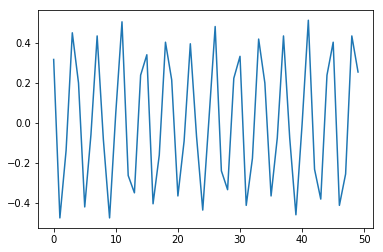

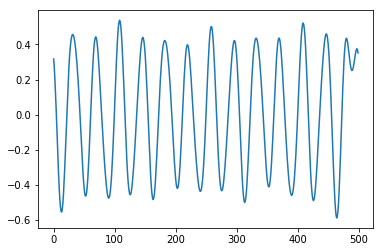

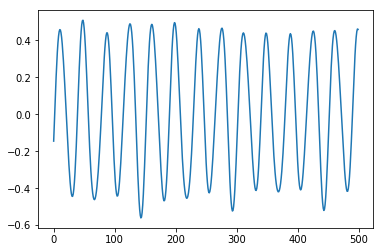

In [49]:
import matplotlib.pyplot as plt
from rtlsdr import *

sdr = RtlSdr()

# configure device
sdr.set_direct_sampling(2) # directly sample I channel
sdr.gain = 1

#samples = sdr.read_samples(256*1024)
samples = sdr.read_samples(256*64)
samples = np.real(samples)
sdr.close()

f = sdr.sample_rate
plt.plot(samples)
plt.xlabel('samples')
plt.ylabel('amplitude')
plt.title('RTLSDR time domain (with AAF)')
plt.show()

zoomed_samples = samples[7450:7500]
plt.plot(zoomed_samples)
plt.show()

from scipy.signal import resample
resampled = resample(zoomed_samples, len(zoomed_samples)*10)
plt.plot(resampled)
plt.show()

resample_then_zoom = resample(samples, len(samples)*10)[100000:100500]
plt.plot(resample_then_zoom)
plt.show()

Nope, it wasn't aliasing.

For some reason, the first 2000 or so samples are nearly zero. 
Maybe a buffering issue?

## Clarification

_Update (8/12/18):_  
It turns out I misunderstood the meaning of the sampled data streamed from the RTL-SDR to the computer over USB.
I thought I was getting a 28.8 Msps datastream from the ADC in the RTL-SDR, but the sample rate of the datastream
sent over USB is actually user-configurable and can be at most 2.5 Msps.
This makes sense, considering that 28.8 Msps of 8 bit samples requires 230 Mb/s of USB bandwidth,
which is close to the maximum usable bandwidth of a USB 2.0 bus (280 Mb/s).
When you also consider that SDR typically uses both I and Q channels, the required bandwidth doubles,
so 28.8 Msps is no doubt infeasible with USB 2.0.

What actually happens in the RTL-SDR is something like this:  
* _(not used in direct sampling mode)_ RF signal is amplified, filtered, and mixed with a Local Oscillator (LO) signal,
whose frequency is slightly offset from the RF carrier frequency.
This shifts the RF signal spectrum from very high frequencies (hundreds of MHz or GHz)
to a lower radio frequency, centered at the so-called [Intermediate Frequency](https://en.wikipedia.org/wiki/Intermediate_frequency) (IF).
In the RTL-SDR, IF is 3.57 MHz.
* The IF signal (centered at 3.57 MHz) is sampled by the ADC at 28.8 MHz.
The resulting signal is now quantized and in discrete-time.
* Using DSP, the signal is downconverted to a complex baseband
(ie. mix sampled signal with IF cosine and sine, yielding I and Q, respectively).
The upper and lower sidebands of the sampled signal get shifted to be below and above DC, respectively.
I and Q are then downsampled to a sample rate up to 2.56 Msps. This signal is then streamed over USB.

In direct sampling mode, something like this would happen:
* RF signal goes directly to 28.8 Msps ADC.
* Using DSP, sampled signal is downconverted by mixing with cosine and sine with frequency equal to the RF signal's carrier. This produces the complex baseband, represented as I and Q.
* I and Q are downsampled, then streamed over USB.

Some block diagrams of the RTL-SDR that I found on the internet:  
![RTL-SDR block diagram](http://i.imgur.com/Fpgu3bO.png)
![another block diagram with details of DDC+resampler](http://aaronscher.com/wireless_com_SDR/docs/rtl_sdr_block.jpg)

What's important to keep in mind here is that as long as the RF signal of interest has a _bandwidth_ of 
less than $F_s/2$, if the sampled signal is purely real.
Since we have complex samples (ie. both I and Q), the RF signal's bandwidth only has to be less than $F_s$.
If this condition is met, then the original signal can be perfectly reconstructed
(barring quantization noise, rounding error, jitter, and other non-idealities).
This is contrary to the common misconception that the signal's maximum frequency must be less than $F_s/2$.
This is only true if all frequencies from DC to the signal's _maximum frequency_ are of interest, which is rarely the case.